In [1]:
with open('baseline.test.pred.txt') as f:
    lines = f.readlines()

In [15]:
baseline_dev_texts = []
with open('baseline.dev.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        baseline_dev_texts += [line]

  0%|          | 0/7374 [00:00<?, ?it/s]

In [10]:
import json

In [11]:

from pathlib import Path
from datasets import Dataset, load_dataset, Split
from data.dataset.data_augmentations import flatten_conversation

data_dir = Path("resources/bart/")

data_files = {
    Split.TRAIN: str((data_dir / "train.history_belief").absolute()),
    Split.VALIDATION: str((data_dir / "val.history_belief").absolute()),
    Split.TEST: str((data_dir / "test.history_belief").absolute()),
}

dataset = load_dataset(
    "data/dataset/multiwoz_dataset.py", data_files=data_files
)
dataset = dataset.map(
    flatten_conversation,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
from tqdm.auto import tqdm
from postprocessing import postprocessing

In [7]:

split="test"
results = {}
turn_id = 0
for prediction_text in tqdm(lines):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in results.keys():
        results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1


  0%|          | 0/7372 [00:00<?, ?it/s]

In [17]:
split="validation"
baseline_dev_results = {}
turn_id = 0
for prediction_text in tqdm(baseline_dev_texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in baseline_dev_results.keys():
        baseline_dev_results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    baseline_dev_results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    baseline_dev_results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1


  0%|          | 0/7374 [00:00<?, ?it/s]

In [18]:
with open("baseline_dev_pred.json", "w") as outfile:
    json.dump(baseline_dev_results, outfile)

In [25]:
adapter_no_c_dev_texts = []
with open('adapter_no_c.dev.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        adapter_no_c_dev_texts += [line]
        
split="validation"
adapter_no_c_dev_results = {}
turn_id = 0
for prediction_text in tqdm(adapter_no_c_dev_texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in adapter_no_c_dev_results.keys():
        adapter_no_c_dev_results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    adapter_no_c_dev_results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    adapter_no_c_dev_results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1
    
with open("adapter_no_c_dev_pred.json", "w") as outfile:
    json.dump(adapter_no_c_dev_results, outfile)

  0%|          | 0/7374 [00:00<?, ?it/s]

  0%|          | 0/7374 [00:00<?, ?it/s]

In [26]:
adapter_no_c_test_texts = []
with open('adapter_no_c.test.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        adapter_no_c_test_texts += [line]
        
split="test"
adapter_no_c_test_results = {}
turn_id = 0
for prediction_text in tqdm(adapter_no_c_test_texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in adapter_no_c_test_results.keys():
        adapter_no_c_test_results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    adapter_no_c_test_results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    adapter_no_c_test_results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1
    
with open("adapter_no_c_test_pred.json", "w") as outfile:
    json.dump(adapter_no_c_test_results, outfile)

  0%|          | 0/7372 [00:00<?, ?it/s]

  0%|          | 0/7372 [00:00<?, ?it/s]

In [2]:
len(lines)

7372

In [9]:
import json

In [5]:
# with open("baseline_test_pred.json", "w") as outfile:
#     json.dump(results, outfile)

In [27]:

with open('baseline_dev_pred.json') as f:
    dev_baseline_results = json.load(f)
with open('baseline_test_pred.json') as f:
    test_baseline_results = json.load(f)
    
with open('adapter_no_c_dev_pred.json') as f:
    dev_adapter_no_c_results = json.load(f)
with open('adapter_no_c_test_pred.json') as f:
    test_adapter_no_c_results = json.load(f)
    

In [6]:
from tqdm.auto import tqdm

from utils.Constants import SLOT_VALS
from utils.dst import ignore_none, default_cleaning

slot_template = {slot: "" for slot in SLOT_VALS}


def get_slot_map(slot_triplet_str_list):
    slot_map = slot_template.copy()
    for slot_triplet_str in slot_triplet_str_list:
        slot_triplets = slot_triplet_str.split()
        key = slot_triplets[0] + " " + slot_triplets[1]
        val = slot_triplets[2:]
        if key not in SLOT_VALS:
            continue
        slot_map[key] = val
    return slot_map

def get_unique_slot_map(preds, targets):
    unique_slots = set()
    pred_map = {}
    target_map = {}
    
    for pred_str in preds:
        triplet = pred_str.split()
        key = triplet[0] + " " + triplet[1]
        val = triplet[2:]
        if key not in SLOT_VALS: continue
        pred_map[key] = val
        unique_slots.add(key)
    
    for target_str in targets:
        triplet = target_str.split()
        key = triplet[0] + " " + triplet[1]
        val = triplet[2:]
        if key not in SLOT_VALS: continue
        target_map[key] = val
        unique_slots.add(key)
    
    return unique_slots.copy(), pred_map.copy(), target_map.copy()


def evaluate_dst(input_results):
    num_turns = 0
    joint_acc = 0
    slot_acc = 0
    r_slot_acc = 0

    num_slots = len(SLOT_VALS)
    num_r_slots = 0

    clean_tokens = ["<s>", "</s>"]
    
    results = input_results.copy()
    
    for dial in tqdm(results.keys()):
        dialogue_pred = results[dial]["generated_turn_belief"]
        dialogue_target = results[dial]["target_turn_belief"]

        for turn_id, (turn_target, turn_pred) in enumerate(
            zip(dialogue_target, dialogue_pred)
        ):
            
            # clean
            for bs in turn_pred:
                if bs in clean_tokens + ["", " "] or bs.split()[-1] == "none":
                    turn_pred.remove(bs)

            new_turn_pred = []
            for bs in turn_pred:
                for tok in clean_tokens:
                    bs = bs.replace(tok, "").strip()
                    new_turn_pred.append(bs)
            turn_pred = new_turn_pred

            turn_pred, turn_target = ignore_none(turn_pred, turn_target)
            # print(turn_pred, turn_target)
            turn_pred, turn_target = default_cleaning(turn_pred, turn_target)

            join_flag = False

            # calculate joint accuracy
            if set(turn_target) == set(turn_pred):
                joint_acc += 1
                join_flag = True

            pred_slot_map = get_slot_map(turn_pred)
            target_slot_map = get_slot_map(turn_target)

            # calculate slot accuracy
            for slot_key in SLOT_VALS:
                if target_slot_map[slot_key] == pred_slot_map[slot_key]:
                    slot_acc += 1

            # calculate relative slot accuracy
            (
                unique_slots,
                unique_pred_map,
                unique_target_map,
            ) = get_unique_slot_map(turn_pred, turn_target)
            for slot_key in unique_slots:
                if slot_key not in unique_target_map.keys():
                    continue
                if slot_key not in unique_pred_map.keys():
                    continue
                if unique_target_map[slot_key] == unique_pred_map[slot_key]:
                    r_slot_acc += 1
            num_r_slots += len(unique_slots)

            num_turns += 1
    joint_acc /= num_turns
    slot_acc /= num_slots * num_turns
    r_slot_acc /= num_r_slots
    print("joint accuracy: {}".format(joint_acc))
    print("slot accuracy: {}".format(slot_acc))
    print("relative slot accuracy: {}".format(r_slot_acc))
    return {
        "joint_acc": joint_acc,
        "slot_acc": slot_acc,
        "r_slot_acc": r_slot_acc,
    }



In [29]:
score = evaluate_dst(dev_baseline_results)
with open("baseline_dev_score.json", "w") as outfile:
    json.dump(score, outfile)

score = evaluate_dst(test_baseline_results)
with open("baseline_test_score.json", "w") as outfile:
    json.dump(score, outfile)
    
score = evaluate_dst(dev_adapter_no_c_results)
with open("adapter_no_c_dev_score.json", "w") as outfile:
    json.dump(score, outfile)

score = evaluate_dst(test_adapter_no_c_results)
with open("adapter_no_c_test_score.json", "w") as outfile:
    json.dump(score, outfile)

  0%|          | 0/1000 [00:00<?, ?it/s]

joint accuracy: 0.012747491185245458
slot accuracy: 0.8551580531422522
relative slot accuracy: 0.0


  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.014378730330982095
slot accuracy: 0.8514606269581503
relative slot accuracy: 0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

joint accuracy: 0.392731217792243
slot accuracy: 0.9668451490415322
relative slot accuracy: 0.7899157334516022


  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.3724905046120456
slot accuracy: 0.9640225438888208
relative slot accuracy: 0.7746471152528437


In [ ]:

score = evaluate_dst(dev_adapter_no_c_results)

In [11]:
len("phil".split())

1

In [24]:
score = evaluate_dst(test_adapter_no_c_results)
with open("adapter_no_c_test_pred.json", "w") as outfile:
    json.dump(score, outfile)

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.3724905046120456
slot accuracy: 0.9640225438888208
relative slot accuracy: 0.7746471152528437


In [2]:
import json
with open("result/adapter_no_c_test_pred.json", "r") as outfile:
    adapter_no_c_test_pred = json.load(outfile)

In [7]:

with open("result/adapter_c_4_epoch_test_pred.json", "r") as outfile:
    adapter_c_test_pred = json.load(outfile)

In [4]:
from evaluate_dst import evaluate_dst

In [5]:
evaluate_dst(adapter_no_c_test_pred)

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.3724905046120456
slot accuracy: 0.9640225438888208
relative slot accuracy: 0.7746471152528437


{'joint_acc': 0.3724905046120456,
 'slot_acc': 0.9640225438888208,
 'r_slot_acc': 0.7746471152528437}

In [8]:
evaluate_dst(adapter_c_test_pred)

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.37696690179055886
slot accuracy: 0.9646220222988465
relative slot accuracy: 0.7760015515044052


{'joint_acc': 0.37696690179055886,
 'slot_acc': 0.9646220222988465,
 'r_slot_acc': 0.7760015515044052}

In [ ]:
adapter_c_test_pred.keys()

In [ ]:
def evaluate_dst_diff(pred_1, pred_2):
    num_turns = 0
    joint_acc = 0
    slot_acc = 0
    r_slot_acc = 0

    num_slots = len(SLOT_VALS)
    num_r_slots = 0

    clean_tokens = ["<s>", "</s>"]
    
    # results = input_results.copy()
    idx = 0
    for dial in tqdm(pred_1.keys()):
        dialogue_pred_1 = pred_1[dial]["generated_turn_belief"]
        dialogue_pred_2 = pred_2[dial]["generated_turn_belief"]
        dialogue_target = pred_1[dial]["target_turn_belief"]

        for turn_id, (turn_target, turn_pred_1, turn_pred_2) in enumerate(
            zip(dialogue_target, dialogue_pred_1, dialogue_pred_2)
        ):
            # print(turn_pred_1, turn_pred_2)
            
            # clean
            for bs in turn_pred_1:
                if bs in clean_tokens + ["", " "] or bs.split()[-1] == "none":
                    turn_pred_1.remove(bs)

            new_turn_pred_1 = []
            for bs in turn_pred_1:
                for tok in clean_tokens:
                    bs = bs.replace(tok, "").strip()
                    new_turn_pred_1.append(bs)
            turn_pred_1 = new_turn_pred_1
            
            
            # clean
            for bs in turn_pred_2:
                if bs in clean_tokens + ["", " "] or bs.split()[-1] == "none":
                    turn_pred_2.remove(bs)

            new_turn_pred_2 = []
            for bs in turn_pred_2:
                for tok in clean_tokens:
                    bs = bs.replace(tok, "").strip()
                    new_turn_pred_2.append(bs)
            turn_pred_2 = new_turn_pred_2
            
            turn_pred_1, _ = ignore_none(turn_pred_1, turn_target)
            turn_pred_2, turn_target = ignore_none(turn_pred_2, turn_target)
            # print(turn_pred, turn_target)
            turn_pred_1, _ = default_cleaning(turn_pred_1, turn_target)
            turn_pred_2, turn_target = default_cleaning(turn_pred_2, turn_target)
            
            join_flag_1 = False
            join_flag_2 = False

            # calculate joint accuracy
            if set(turn_target) == set(turn_pred_1):
                join_flag_1 = True
            if set(turn_target) == set(turn_pred_2):
                join_flag_2 = True
            
            if join_flag_1 != join_flag_2:
                print(idx, turn_pred_1, turn_pred_2, turn_target)
                print(join_flag_1, join_flag_2)
                
            idx += 1
            # pred_slot_map = get_slot_map(turn_pred)
            # target_slot_map = get_slot_map(turn_target)

#             # calculate slot accuracy
#             for slot_key in SLOT_VALS:
#                 if target_slot_map[slot_key] == pred_slot_map[slot_key]:
#                     slot_acc += 1

#             # calculate relative slot accuracy
#             (
#                 unique_slots,
#                 unique_pred_map,
#                 unique_target_map,
#             ) = get_unique_slot_map(turn_pred, turn_target)
#             for slot_key in unique_slots:
#                 if slot_key not in unique_target_map.keys():
#                     continue
#                 if slot_key not in unique_pred_map.keys():
#                     continue
#                 if unique_target_map[slot_key] == unique_pred_map[slot_key]:
#                     r_slot_acc += 1
#             num_r_slots += len(unique_slots)

#             num_turns += 1
#     joint_acc /= num_turns
#     slot_acc /= num_slots * num_turns
#     r_slot_acc /= num_r_slots
#     print("joint accuracy: {}".format(joint_acc))
#     print("slot accuracy: {}".format(slot_acc))
#     print("relative slot accuracy: {}".format(r_slot_acc))
#     return {
#         "joint_acc": joint_acc,
#         "slot_acc": slot_acc,
#         "r_slot_acc": r_slot_acc,
#     }
evaluate_dst_diff(adapter_no_c_test_pred, adapter_c_test_pred)

In [7]:
adapter_no_c_test_texts = []
with open('adapter_no_c_more_train.test.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        adapter_no_c_test_texts += [line]

  0%|          | 0/7372 [00:00<?, ?it/s]

In [8]:
adapter_c_test_texts = []
with open('result/adapter_c.test.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        adapter_c_test_texts += [line]

  0%|          | 0/7372 [00:00<?, ?it/s]

In [51]:
idx = 6655
adapter_no_c_test_texts[idx], adapter_c_test_texts[idx]

("<s><s> <|context|> <|user|> i am looking for european restaurant in the centre. <|system|> i see there are several, can you make a recommendation? <|user|> i haven't tried any in that area before. what would you suggest? <|system|> i have the eraina that is expensive or the riverside brasserie which is in the moderate range. <|user|> can i get the phone number and postcode for eraina, please? <|endofcontext|> <|belief|> restaurant food european, restaurant pricerange not mentioned, restaurant name eraina, restaurant area centre <|endofbelief|> </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>

In [9]:
import re

def postprocessing(ds):
    """
    input ds: dialog state for the current turn as string
    return prediction: valued prediction as list of triplet
    """
    current_belief = re.search("<\|belief\|> (.*) <\|endofbelief\|>", clean_ds)
    
    if not current_belief:
        return []
    
    current_belief = current_belief.group(1)
    belief_list = re.split(
        ",", current_belief
    )  # here can split by ", domain", in case using commas alone is not enough
    # print(belief_list)
    prediction = []
    for x in belief_list:
        not_mentioned = re.search("not mentioned", x)
        if not_mentioned == None and x.strip() and len(x.split()) > 2:
            prediction.append(x)

    return prediction
sample = adapter_no_c_test_texts[idx]
sample, postprocessing(sample)

NameError: name 'idx' is not defined

In [10]:
split="test"
adapter_no_c_test_results = {}
turn_id = 0
for prediction_text in tqdm(adapter_no_c_test_texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in adapter_no_c_test_results.keys():
        adapter_no_c_test_results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    adapter_no_c_test_results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    adapter_no_c_test_results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1

  0%|          | 0/7372 [00:00<?, ?it/s]

NameError: name 'clean_ds' is not defined

In [49]:
from evaluate_dst import evaluate_dst
evaluate_dst(adapter_no_c_test_results)

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.37425393380358113
slot accuracy: 0.964079428701451
relative slot accuracy: 0.7749972590724701


{'joint_acc': 0.37425393380358113,
 'slot_acc': 0.964079428701451,
 'r_slot_acc': 0.7749972590724701}

In [ ]:
split="test"
adapter_no_c_test_results = {}
turn_id = 0
for prediction_text in tqdm(adapter_no_c_test_texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in adapter_no_c_test_results.keys():
        adapter_no_c_test_results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    adapter_no_c_test_results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(prediction_text)
    ]
    adapter_no_c_test_results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1

In [14]:
from postprocessing import postprocessing
def prediction_for_each_turn(prediction_texts, split="validation"):
    output = {}
    turn_id = 0
    
    for prediction_text in tqdm(prediction_texts):
        gold_text = dataset[split]["turn"][turn_id]

        dialogue_id = dataset[split]["conversation_id"][turn_id]
        turn_num = dataset[split]["turn_number"][turn_id]
        if turn_num not in output.keys():
            output[turn_num] = {}
            
        if dialogue_id not in output[turn_num].keys():
            output[turn_num][dialogue_id] = {
                "generated_turn_belief": [],
                "target_turn_belief": [],
            }

        output[turn_num][dialogue_id]["generated_turn_belief"] += [
            postprocessing(prediction_text)
        ]
        output[turn_num][dialogue_id]["target_turn_belief"] += [
            postprocessing(gold_text)
        ]

        turn_id += 1
    return output.copy()


In [60]:
dataset["validation"]["turn_number"][:20]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3]

In [15]:
result = prediction_for_each_turn(adapter_no_c_test_texts, "test")

  0%|          | 0/7372 [00:00<?, ?it/s]

In [16]:
result_c = prediction_for_each_turn(adapter_c_test_texts, "test")

  0%|          | 0/7372 [00:00<?, ?it/s]

In [17]:
score_by_turn = {}
for turn_num in result.keys():
    score_by_turn[turn_num] = evaluate_dst(result[turn_num])

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.8588588588588588
slot accuracy: 0.994930414285253
relative slot accuracy: 0.8987749838813669


  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.6676676676676677
slot accuracy: 0.986567212373664
relative slot accuracy: 0.8495479204339964


  0%|          | 0/990 [00:00<?, ?it/s]

joint accuracy: 0.4797979797979798
slot accuracy: 0.9776148582600196
relative slot accuracy: 0.8052168982137794


  0%|          | 0/943 [00:00<?, ?it/s]

joint accuracy: 0.4019088016967126
slot accuracy: 0.9723600041049499
relative slot accuracy: 0.8145938503900872


  0%|          | 0/872 [00:00<?, ?it/s]

joint accuracy: 0.30160550458715596
slot accuracy: 0.9665211601065404
relative slot accuracy: 0.8157948300427438


  0%|          | 0/790 [00:00<?, ?it/s]

joint accuracy: 0.24556962025316456
slot accuracy: 0.9583911800734994
relative slot accuracy: 0.8002352479905901


  0%|          | 0/670 [00:00<?, ?it/s]

joint accuracy: 0.1925373134328358
slot accuracy: 0.9519017814155031
relative slot accuracy: 0.7920482930890924


  0%|          | 0/465 [00:00<?, ?it/s]

joint accuracy: 0.17204301075268819
slot accuracy: 0.9483177245924385
relative slot accuracy: 0.7939142461964038


  0%|          | 0/292 [00:00<?, ?it/s]

joint accuracy: 0.1404109589041096
slot accuracy: 0.9418912947414936
relative slot accuracy: 0.7816521378165214


  0%|          | 0/171 [00:00<?, ?it/s]

joint accuracy: 0.08771929824561403
slot accuracy: 0.9341633654027542
relative slot accuracy: 0.7682602921646746


  0%|          | 0/96 [00:00<?, ?it/s]

joint accuracy: 0.08333333333333333
slot accuracy: 0.925739247311828
relative slot accuracy: 0.7519640852974186


  0%|          | 0/48 [00:00<?, ?it/s]

joint accuracy: 0.041666666666666664
slot accuracy: 0.9193548387096774
relative slot accuracy: 0.7413793103448276


  0%|          | 0/21 [00:00<?, ?it/s]

joint accuracy: 0.09523809523809523
slot accuracy: 0.9354838709677419
relative slot accuracy: 0.7835051546391752


  0%|          | 0/7 [00:00<?, ?it/s]

joint accuracy: 0.2857142857142857
slot accuracy: 0.9585253456221198
relative slot accuracy: 0.85


  0%|          | 0/5 [00:00<?, ?it/s]

joint accuracy: 0.2
slot accuracy: 0.9548387096774194
relative slot accuracy: 0.8409090909090909


  0%|          | 0/2 [00:00<?, ?it/s]

joint accuracy: 0.0
slot accuracy: 0.9354838709677419
relative slot accuracy: 0.7647058823529411


  0%|          | 0/1 [00:00<?, ?it/s]

joint accuracy: 0.0
slot accuracy: 0.9032258064516129
relative slot accuracy: 0.7272727272727273


  0%|          | 0/1 [00:00<?, ?it/s]

joint accuracy: 0.0
slot accuracy: 0.967741935483871
relative slot accuracy: 0.9090909090909091


In [18]:
score_by_turn_c = {}
for turn_num in result_c.keys():
    score_by_turn_c[turn_num] = evaluate_dst(result_c[turn_num])

  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.8538538538538538
slot accuracy: 0.994930414285253
relative slot accuracy: 0.898970398970399


  0%|          | 0/999 [00:00<?, ?it/s]

joint accuracy: 0.6726726726726727
slot accuracy: 0.986857825567503
relative slot accuracy: 0.8529092880375858


  0%|          | 0/990 [00:00<?, ?it/s]

joint accuracy: 0.4676767676767677
slot accuracy: 0.9776800260671228
relative slot accuracy: 0.8061137843192754


  0%|          | 0/943 [00:00<?, ?it/s]

joint accuracy: 0.3987274655355249
slot accuracy: 0.9711969349707522
relative slot accuracy: 0.8073667353008465


  0%|          | 0/872 [00:00<?, ?it/s]

joint accuracy: 0.3084862385321101
slot accuracy: 0.9660032554010062
relative slot accuracy: 0.8129071661237784


  0%|          | 0/790 [00:00<?, ?it/s]

joint accuracy: 0.2569620253164557
slot accuracy: 0.9591670069416088
relative slot accuracy: 0.8034204835856104


  0%|          | 0/670 [00:00<?, ?it/s]

joint accuracy: 0.2044776119402985
slot accuracy: 0.9514203177660087
relative slot accuracy: 0.7893967856397411


  0%|          | 0/465 [00:00<?, ?it/s]

joint accuracy: 0.1956989247311828
slot accuracy: 0.9477627471383975
relative slot accuracy: 0.7912392570002772


  0%|          | 0/292 [00:00<?, ?it/s]

joint accuracy: 0.15753424657534246
slot accuracy: 0.9406760936809545
relative slot accuracy: 0.7767151767151768


  0%|          | 0/171 [00:00<?, ?it/s]

joint accuracy: 0.1111111111111111
slot accuracy: 0.9313337106206376
relative slot accuracy: 0.7584605175846052


  0%|          | 0/96 [00:00<?, ?it/s]

joint accuracy: 0.09375
slot accuracy: 0.9206989247311828
relative slot accuracy: 0.7360178970917226


  0%|          | 0/48 [00:00<?, ?it/s]

joint accuracy: 0.08333333333333333
slot accuracy: 0.9233870967741935
relative slot accuracy: 0.7558886509635975


  0%|          | 0/21 [00:00<?, ?it/s]

joint accuracy: 0.14285714285714285
slot accuracy: 0.9308755760368663
relative slot accuracy: 0.7715736040609137


  0%|          | 0/7 [00:00<?, ?it/s]

joint accuracy: 0.2857142857142857
slot accuracy: 0.9585253456221198
relative slot accuracy: 0.8571428571428571


  0%|          | 0/5 [00:00<?, ?it/s]

joint accuracy: 0.2
slot accuracy: 0.9612903225806452
relative slot accuracy: 0.8695652173913043


  0%|          | 0/2 [00:00<?, ?it/s]

joint accuracy: 0.5
slot accuracy: 0.9838709677419355
relative slot accuracy: 0.9411764705882353


  0%|          | 0/1 [00:00<?, ?it/s]

joint accuracy: 0.0
slot accuracy: 0.967741935483871
relative slot accuracy: 0.9090909090909091


  0%|          | 0/1 [00:00<?, ?it/s]

joint accuracy: 0.0
slot accuracy: 0.967741935483871
relative slot accuracy: 0.9090909090909091


In [21]:
import matplotlib.pyplot as plt
import numpy as np

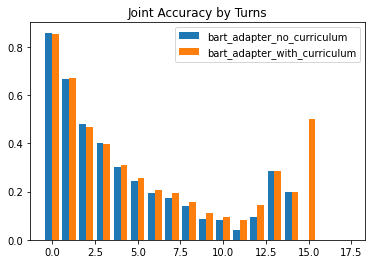

In [22]:
x = list(score_by_turn.keys())
x.sort()
y = [score_by_turn[key]["joint_acc"] for key in x]

x_c = list(score_by_turn_c.keys())
x_c.sort()
y_c = [score_by_turn_c[key]["joint_acc"] for key in x_c]


fig, ax = plt.subplots()
X_axis = np.arange(len(x))
ax.bar(X_axis-0.2, y, 0.4, label="bart_adapter_no_curriculum")
ax.bar(X_axis+0.2, y_c, 0.4, label="bart_adapter_with_curriculum")
ax.set_title('Joint Accuracy by Turns')
ax.legend()
fig.savefig(f"joint_acc_by_turns.jpg", dpi=300, bbox_inches="tight")

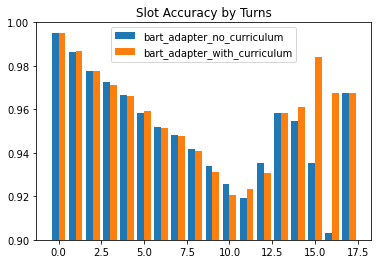

In [23]:
x = list(score_by_turn.keys())
x.sort()
y = [score_by_turn[key]["slot_acc"] for key in x]

x_c = list(score_by_turn_c.keys())
x_c.sort()
y_c = [score_by_turn_c[key]["slot_acc"] for key in x_c]


fig, ax = plt.subplots()
X_axis = np.arange(len(x))
ax.set_ylim([0.9, 1])
ax.bar(X_axis-0.2, y, 0.4, label="bart_adapter_no_curriculum")
ax.bar(X_axis+0.2, y_c, 0.4, label="bart_adapter_with_curriculum")
ax.set_title('Slot Accuracy by Turns')
ax.legend()
fig.savefig(f"slot_acc_by_turns.jpg", dpi=300, bbox_inches="tight")

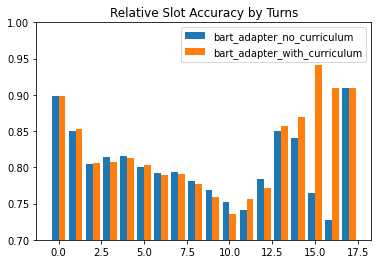

In [24]:
x = list(score_by_turn.keys())
x.sort()
y = [score_by_turn[key]["r_slot_acc"] for key in x]

x_c = list(score_by_turn_c.keys())
x_c.sort()
y_c = [score_by_turn_c[key]["r_slot_acc"] for key in x_c]

fig, ax = plt.subplots()
X_axis = np.arange(len(x))
ax.set_ylim([0.7, 1])
ax.bar(X_axis-0.2, y, 0.4, label="bart_adapter_no_curriculum")
ax.bar(X_axis+0.2, y_c, 0.4, label="bart_adapter_with_curriculum")
ax.set_title('Relative Slot Accuracy by Turns')
ax.legend()
fig.savefig(f"r_slot_acc_by_turns.jpg", dpi=300, bbox_inches="tight")

In [29]:
from tqdm.auto import tqdm

from utils.Constants import SLOT_VALS
from utils.dst import ignore_none, default_cleaning

slot_template = {slot: "" for slot in SLOT_VALS}


def get_slot_map(slot_triplet_str_list):
    slot_map = slot_template.copy()
    for slot_triplet_str in slot_triplet_str_list:
        slot_triplets = slot_triplet_str.split()
        key = slot_triplets[0] + " " + slot_triplets[1]
        val = slot_triplets[2:]
        if key not in SLOT_VALS:
            continue
        slot_map[key] = val
    return slot_map


def get_unique_slot_map(preds, targets):
    unique_slots = set()
    pred_map = {}
    target_map = {}

    for pred_str in preds:
        triplet = pred_str.split()
        key = triplet[0] + " " + triplet[1]
        val = triplet[2:]
        if key not in SLOT_VALS:
            continue
        pred_map[key] = val
        unique_slots.add(key)

    for target_str in targets:
        triplet = target_str.split()
        key = triplet[0] + " " + triplet[1]
        val = triplet[2:]
        if key not in SLOT_VALS:
            continue
        target_map[key] = val
        unique_slots.add(key)

    return unique_slots.copy(), pred_map.copy(), target_map.copy()


def evaluate_dst(input_results):
    num_turns = 0
    joint_acc = 0
    slot_acc = 0
    r_slot_acc = 0

    num_slots = len(SLOT_VALS)
    num_r_slots = 0

    clean_tokens = ["<s>", "</s>"]

    results = input_results.copy()

    for dial in tqdm(results.keys()):
        dialogue_pred = results[dial]["generated_turn_belief"]
        dialogue_target = results[dial]["target_turn_belief"]
        # print(dialogue_pred, dialogue_target)
        for turn_id, (turn_target, turn_pred) in enumerate(
            zip(dialogue_target, dialogue_pred)
        ):

            # clean
            for bs in turn_pred:
                if bs in clean_tokens + ["", " "] or bs.split()[-1] == "none":
                    turn_pred.remove(bs)

            new_turn_pred = []
            for bs in turn_pred:
                for tok in clean_tokens:
                    bs = bs.replace(tok, "").strip()
                    new_turn_pred.append(bs)
            turn_pred = new_turn_pred

            turn_pred, turn_target = ignore_none(turn_pred, turn_target)
            # if num_turns==3441:
            #     print(turn_pred, turn_target)
            # print(num_turns)
            turn_pred, turn_target = default_cleaning(turn_pred, turn_target)
            # if num_turns==3441:
            #     print(turn_pred, turn_target)

            join_flag = False

            # calculate joint accuracy
            if set(turn_target) == set(turn_pred):
                joint_acc += 1
                join_flag = True

            pred_slot_map = get_slot_map(turn_pred)
            target_slot_map = get_slot_map(turn_target)

            # calculate slot accuracy
            for slot_key in SLOT_VALS:
                if target_slot_map[slot_key] == pred_slot_map[slot_key]:
                    slot_acc += 1

            # calculate relative slot accuracy
            (
                unique_slots,
                unique_pred_map,
                unique_target_map,
            ) = get_unique_slot_map(turn_pred, turn_target)
            for slot_key in unique_slots:
                if slot_key not in unique_target_map.keys():
                    continue
                if slot_key not in unique_pred_map.keys():
                    continue
                if unique_target_map[slot_key] == unique_pred_map[slot_key]:
                    r_slot_acc += 1
            num_r_slots += len(unique_slots)

            num_turns += 1
    joint_acc /= num_turns
    slot_acc /= num_slots * num_turns
    r_slot_acc /= num_r_slots
    print("joint accuracy: {}".format(joint_acc))
    print("slot accuracy: {}".format(slot_acc))
    print("relative slot accuracy: {}".format(r_slot_acc))
    return {
        "joint_acc": joint_acc,
        "slot_acc": slot_acc,
        "r_slot_acc": r_slot_acc,
    }


In [8]:
texts = []
with open('bart_finetune_course_4_with_modified_inference.test.pred.txt') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        texts += [line]

  0%|          | 0/7372 [00:00<?, ?it/s]

In [35]:
import re


def postprocessing(ds):
    """
    input ds: dialog state for the current turn as string
    return prediction: valued prediction as list of triplet
    """
    eob_token = "<|endofbelief|>"
    if eob_token in ds:
        ds = ds[:ds.index(eob_token)] + eob_token
    current_belief = re.search("<\|belief\|> (.*) <\|endofbelief\|>", ds)
    
    if not current_belief:
        return []
    
    current_belief = current_belief.group(1)

    belief_list = re.split(
        ", ", current_belief
    )  # here can split by ", domain", in case using commas alone is not enough
    prediction = []
    for x in belief_list:
        not_mentioned = re.search("not mentioned", x)
        if not_mentioned == None and x.strip() and len(x.strip().split()) > 2:
            prediction.append(x)

    return prediction



In [36]:
# from postprocessing import postprocessing
split = "test"
turn_id = 0
results = {}
for text in tqdm(texts):
    gold_text = dataset[split]["turn"][turn_id]

    dialogue_id = dataset[split]["conversation_id"][turn_id]
    if dialogue_id not in results.keys():
        results[dialogue_id] = {
            "generated_turn_belief": [],
            "target_turn_belief": [],
        }

    results[dialogue_id]["generated_turn_belief"] += [
        postprocessing(text)
    ]
    results[dialogue_id]["target_turn_belief"] += [
        postprocessing(gold_text)
    ]

    turn_id += 1

  0%|          | 0/7372 [00:00<?, ?it/s]

In [37]:
evaluate_dst(results)

  0%|          | 0/999 [00:00<?, ?it/s]

['hotel parking people none mentioned', 'hotel parking people none mentioned', 'train departure cambridge', 'train departure cambridge', 'train name than mentioned', 'train name than mentioned', 'attraction book time none mentioned', 'attraction book time none mentioned', 'attraction pr than mentioned', 'attraction pr than mentioned', 'attraction departure than mentioned', 'attraction departure than mentioned', 'restaurant arriveat 10 mentioned', 'restaurant arriveat 10 mentioned'] ['restaurant name thanh binh ', 'train leaveat 10:30 ', 'train destination norwich ', 'train day thursday ', 'train departure cambridge ', 'train book people 8']
['hotel parking people none mentioned', 'hotel parking people none mentioned', 'train departure cambridge', 'train departure cambridge', 'train name than mentioned', 'train name than mentioned', 'attraction book time none mentioned', 'attraction book time none mentioned', 'attraction pr than mentioned', 'attraction pr than mentioned', 'attraction de

{'joint_acc': 0.00013564839934888768,
 'slot_acc': 0.8183492902525685,
 'r_slot_acc': 0.03878392145966472}

In [31]:
import json
with open('bart_finetune_course_4_with_modified_inference_test_pred.json') as f:
    modified_inference_ds = json.load(f)

In [32]:
evaluate_dst(modified_inference_ds)

  0%|          | 0/999 [00:00<?, ?it/s]

['hotel parking people none mentioned', 'hotel parking people none mentioned', 'train departure cambridge', 'train departure cambridge', 'train name than mentioned', 'train name than mentioned', 'attraction book time none mentioned', 'attraction book time none mentioned', 'attraction pr than mentioned', 'attraction pr than mentioned', 'attraction departure than mentioned', 'attraction departure than mentioned', 'restaurant arriveat 10 mentioned', 'restaurant arriveat 10 mentioned', '</s></s></s></s> <|endofbelief|> </s></s></s></s>', '<|endofbelief|>', '</s></s> book nor mentioned', 'book nor mentioned', 'train bookat 10 mentioned', 'train bookat 10 mentioned', '</s> area people not', 'area people not', '</s> train</s></s>at mentioned', 'trainat mentioned', 'train</s></s> not th', 'train not th'] ['restaurant name thanh binh ', 'train leaveat 10:30 ', 'train destination norwich ', 'train day thursday ', 'train departure cambridge ', 'train book people 8']


IndexError: list index out of range

In [22]:
default_cleaning(['attraction type queens mentioned', 'attraction type queens mentioned', 'hotel book stay 1 mentioned', 'hotel book stay 1 mentioned', 'hotel parking day m mentioned', 'hotel parking day m mentioned', 'attraction departure day none mentioned', 'attraction departure day none mentioned'], [])

(['attraction type queens mentioned',
  'attraction type queens mentioned',
  'hotel book stay 1 mentioned',
  'hotel book stay 1 mentioned',
  'hotel parking day m mentioned',
  'hotel parking day m mentioned',
  'attraction departure day none mentioned',
  'attraction departure day none mentioned'],
 [])

In [ ]:
evaluate_dst(results)